In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 모델 별 정확도
- Cnn with vgg 16 : 99.4%
- Resnet : 99.01%
- Cnn : 98.68%

# 데이터 불러오기
- 21개의 알약 데이터 47개의 마약(크롤링을 통해 수집)
> 총 3796장 데이터

In [7]:
import os
import glob

# 파일 경로 설정
image_files = glob.glob("/content/drive/MyDrive/MedicineContest/drug&medicine/*/*")

# 폴더명 추출
folder_names = {os.path.basename(os.path.dirname(file_path)) for file_path in image_files}

print('파일명 : ', folder_names)
print('파일 개수 :' ,len(folder_names))

파일명 :  {'195 Ethchlorvynol', '253 Mazindol', '107 Halazepam', '295 2C-B', '37990 Multi-Q10', '168 Zolpidem', '41207 Vtamin Tab', '22 Etizolam', '41172 Levetiracetam', '149 Clotiazepam', '139 Fenetylline', '155 Clorazepate', '78 Phenazepam', '11 Locaserin', '259 Diazepam', '239 Meprobamate', '166 Zipeprol', '162 Carisoprodol', '282 5-MeO-DiPT', '41097 Kyungdong Fanitine Tab', '161 Camazepam', '28 Methylenedioxypyrovalerone,MDPV', '238 Mexazolam', '40720 New Glia Tab', '116 Flunitrazepam', '233 Benzphetamine', '40949 Afental CR Tab', '245 Methylphenidate', '9 AL-LAD', '40837 Duosta Tab', '40990 Sebaco Hct Tab', '30 W-18', '41344 Tovast Tab', '224 Bromazepam', '1 Reminazolam', '133 Phendimetrazine', '138 Phenobarbital', '194 Estazolam', '12 Quazepam', '40953 Canagabarotin Cap', '170 Ibogaine', '40991 Sebaco Hct Tab', '114 Flurazepam', '128 Pentazocine', '156 Clonazepam', '152 Chlordiazepoxide', '193 Ethyl Loflazepate', '150 Clobazam', '303 Phenibut', '41107 Anacox Cap', '59 4,4_DMAR', '34

In [8]:
import cv2
import numpy as np
import os

# 이미지 파일 경로 설정
image_files = glob.glob("/content/drive/MyDrive/MedicineContest/drug&medicine/*/*")

# 이미지와 라벨을 저장할 리스트 생성
images = []  # 이미지 데이터를 저장할 리스트
labels = []  # 라벨 데이터를 저장할 리스트

# 이미지 파일을 읽어서 이미지 데이터(images)와 라벨 데이터(labels)에 저장
for file_path in image_files:
    # 이미지 파일의 경로에서 라벨(폴더 이름)을 추출
    label = os.path.basename(os.path.dirname(file_path))
    # 이미지 파일 읽기
    img = cv2.imread(file_path)
    # 이미지 크기 조정 (선택적)
    img = cv2.resize(img, (150, 150))
    # 이미지 데이터(images)와 라벨 데이터(labels)에 추가
    images.append(img)
    labels.append(label)

# 리스트를 넘파이 배열로 변환
images = np.array(images)
labels = np.array(labels)

# 데이터셋의 크기 확인
print("이미지 데이터의 크기:", images.shape)
print("라벨 데이터의 크기:", labels.shape)

이미지 데이터의 크기: (3796, 150, 150, 3)
라벨 데이터의 크기: (3796,)


In [9]:
from sklearn.preprocessing import LabelEncoder

# 라벨 인코더 생성
label_encoder = LabelEncoder()

# 라벨 데이터를 숫자 형태로 변환
labels_encoded = label_encoder.fit_transform(labels)

## Train/Test로 구분하기

In [10]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

x_train, x_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.2, random_state=42)
x_train.shape,y_train.shape

((3036, 150, 150, 3), (3036,))

# 모델 설계

### vgg16 transfer

In [11]:
x_train_scaled=x_train/255.0
x_test_scaled=x_test/255.0

In [12]:
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
import tensorflow.keras

# VGG모델 불러오기
vgg_base = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(150,150,3))

vgg_base.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

### vgg 모델 설계

In [13]:
from keras.models import Sequential
from keras import layers

# 모델 생성
model_vgg = Sequential()
model_vgg.add(vgg_base)
model_vgg.add(layers.Flatten())
model_vgg.add(layers.Dense(256, activation='relu'))
model_vgg.add(layers.Dropout(0.5))
model_vgg.add(layers.Dense(68, activation='softmax'))

In [14]:
# VGG16의 Convolutional Layer는 이미 학습되어 있으므로 학습되지 않도록 설정
vgg_base.trainable = False

In [15]:
# 모델 컴파일
model_vgg.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['accuracy'])

# 모델 학습
history_vgg = model_vgg.fit(x_train_scaled, y_train, batch_size=32, epochs=50, validation_split=0.3)

Epoch 1/50
67/67 [==============================] - 19s 164ms/step - loss: 3.2178 - accuracy: 0.2405 - val_loss: 2.0623 - val_accuracy: 0.4566
Epoch 2/50
67/67 [==============================] - 6s 88ms/step - loss: 1.6825 - accuracy: 0.5393 - val_loss: 1.1024 - val_accuracy: 0.7234
Epoch 3/50
67/67 [==============================] - 7s 102ms/step - loss: 1.0827 - accuracy: 0.6847 - val_loss: 0.6585 - val_accuracy: 0.8244
Epoch 4/50
67/67 [==============================] - 6s 89ms/step - loss: 0.7641 - accuracy: 0.7652 - val_loss: 0.5155 - val_accuracy: 0.8386
Epoch 5/50
67/67 [==============================] - 6s 91ms/step - loss: 0.5917 - accuracy: 0.8344 - val_loss: 0.3745 - val_accuracy: 0.8727
Epoch 6/50
67/67 [==============================] - 7s 102ms/step - loss: 0.4501 - accuracy: 0.8588 - val_loss: 0.2649 - val_accuracy: 0.9265
Epoch 7/50
67/67 [==============================] - 7s 104ms/step - loss: 0.3749 - accuracy: 0.8809 - val_loss: 0.1962 - val_accuracy: 0.9462
Epoch 8/

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
# 모델 평가
test_loss, test_acc = model_vgg.evaluate(x_test_scaled, y_test)
print(f"Test Accuracy: {test_acc}")

# 예측값 계산
y_pred = model_vgg.predict(x_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)

# 혼동 행렬
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

# Classification Report
class_report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)
print("Classification Report:\n", class_report)

24/24 [==============================] - 5s 192ms/step - loss: 0.0248 - accuracy: 0.9921
Test Accuracy: 0.99210524559021
24/24 [==============================] - 2s 70ms/step
Confusion Matrix:
 [[ 8  0  0 ...  0  0  0]
 [ 0  7  0 ...  0  0  0]
 [ 0  0 23 ...  0  0  0]
 ...
 [ 0  0  0 ...  7  0  0]
 [ 0  0  0 ...  0  5  0]
 [ 0  0  0 ...  0  0  4]]
Classification Report:
                                     precision    recall  f1-score   support

                     1 Reminazolam       1.00      1.00      1.00         8
                     107 Halazepam       1.00      1.00      1.00         7
                      11 Locaserin       1.00      1.00      1.00        23
                    114 Flurazepam       1.00      1.00      1.00         5
                 116 Flunitrazepam       1.00      1.00      1.00        15
                       12 Quazepam       1.00      1.00      1.00        36
                   128 Pentazocine       1.00      1.00      1.00        10
               13

In [17]:
# 모델 저장
model_vgg.save('/content/drive/MyDrive/MedicineContest/vgg16_transfer.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers

# 데이터 전처리 (학습과 동일하게 적용)
x_test_scaled = x_test / 255.0  # 예시 스케일링

# 모델 평가
test_loss, test_accuracy = model_vgg.evaluate(x_test_scaled, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# 예측 수행
y_pred = model_vgg.predict(x_test_scaled)

# y_pred 값을 라벨로 변환 (softmax 결과를 예측 클래스로 변환)
y_pred_classes = np.argmax(y_pred, axis=1)

# y_test가 이미 sparse 형식인지 확인
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_test = np.argmax(y_test, axis=1)

24/24 [==============================] - 2s 69ms/step - loss: 0.0248 - accuracy: 0.9921
Test Loss: 0.024795828387141228
Test Accuracy: 0.99210524559021
24/24 [==============================] - 2s 70ms/step


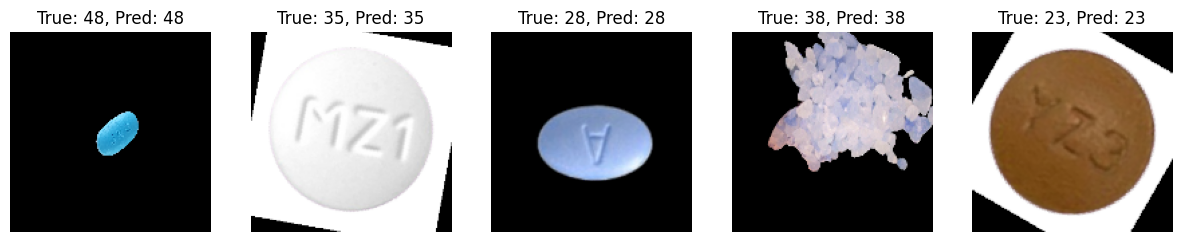

In [19]:
num_images = 5  # 시각화할 이미지 개수
random_indices = np.random.choice(len(x_test), num_images, replace=False)

plt.figure(figsize=(15, 10))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_test[idx])
    plt.title(f"True: {y_test[idx]}, Pred: {y_pred_classes[idx]}")
    plt.axis('off')
plt.show()


In [20]:
print("Encoded labels:", labels_encoded)

# 숫자 라벨을 원본 라벨로 디코딩
decoded_labels = label_encoder.inverse_transform(labels_encoded)
print("Decoded labels:", decoded_labels)

Encoded labels: [42 42 42 ... 62 62 62]
Decoded labels: ['30 W-18' '30 W-18' '30 W-18' ... '41327 Rabeprazole Sodium'
 '41327 Rabeprazole Sodium' '41327 Rabeprazole Sodium']


In [21]:
# 일반 약물과 마약을 분류할 빈 리스트 생성
general_drugs = []
narcotics = []

# 숫자가 4자리 이상인지 확인하여 분류
for label in decoded_labels:
    # 라벨에서 첫 번째 공백이 나오기 전까지의 문자열을 숫자로 변환
    num_part = label.split(' ')[0]

    # 숫자가 4자리 이상인지 확인
    if len(num_part) >= 4:
        general_drugs.append(label)
    else:
        narcotics.append(label)

# 결과 출력
print("General Drugs:")
print(general_drugs)

print("\nNarcotics:")
print(narcotics)

General Drugs:
['41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '40990 Sebaco Hct Tab', '40990 Sebaco Hct Tab', '40990 Sebaco Hct Tab', '40990 Sebaco Hct Tab', '40990 Sebaco Hct Tab', '40990 Sebaco Hct Tab', '40990 Sebaco Hct Tab', '40990 Sebaco Hc

In [22]:
# 마약류와 일반 약물 판단 함수
def classify_drug(label):
    # 라벨에서 숫자 부분 추출
    num_part = label.split(' ')[0]
    # 숫자가 4자리 이상인지 확인
    if len(num_part) >= 4:
        return 'medicine'
    else:
        return 'psychotropic drugs'

In [38]:
decoded_labels[481]

'1 Reminazolam'

In [24]:
# 일반 약품 라벨만 골라내기
medicine_labels = [label for label in decoded_labels if classify_drug(label) == 'medicine']
print("Medicine Labels:", medicine_labels)

Medicine Labels: ['41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '41107 Anacox Cap', '40990 Sebaco Hct Tab', '40990 Sebaco Hct Tab', '40990 Sebaco Hct Tab', '40990 Sebaco Hct Tab', '40990 Sebaco Hct Tab', '40990 Sebaco Hct Tab', '40990 Sebaco Hct Tab', '40990 Sebaco 

### 오류 원인 파악

In [37]:
# 마약 라벨만 골라내기 => 멀쩡한데..?
narcotic_labels = [label for label in decoded_labels if classify_drug(label) == 'psychotropic drugs']
print("Narcotic Labels:", narcotic_labels)

Narcotic Labels: ['30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '30 W-18', '28 Methylenedioxypyrovalerone,MDPV', '28 Methylenedioxypyrovalerone,MDPV', '28 Methylenedioxypyrovalerone,MDPV', '28 Methylenedioxypyrovalerone,MDPV', '28 Methylenedioxypyrovalerone,MDPV', 

In [56]:
y_test[759]  # 인덱스 0~759 -> decoded_labels[71] y_test.shape() : (760,)

33

In [69]:
decoded_labels[71] # decoded_labels[0~71] 값이 전부 '30 W-18'

'30 W-18'

In [70]:
decoded_labels[72] # decoded_labels[72] 인덱스 72부터 값 '28 Methylenedioxypyrovalerone,MDPV' 로 변경

'28 Methylenedioxypyrovalerone,MDPV'

### ⚠️**문제 파악**⚠️
* decoded_labels가 디코딩되면서 순서대로 값이 쌓인 듯
  * ex) decoded_labels[0~71] (인덱스 0부터 71까지의 값) = '30 W-18'
  *     decoded_labels[72~107] (인덱스 72부터 107까지의 값) = '28 Methylenedioxypyrovalerone,MDPV'

* 반면, y_test는 총 760개의 데이터로 인덱싱해보면
  * y_test[0~759] (모든 값들)의 인덱스 범위가 0  ~ 67임
  * 그러니까, decoded_labels[y_test[i]] 값이 전부 '30 W-18'가 나올 수 밖에 없는 것
  * decoded_labes[0~67] 값들은 모두 위에서 설명한대로 '30 W-18'이므로 밑에 코드를 실행하면 모든 알약명이 '30 W-18'로 동일하게 나오는 것임

In [74]:
## decoded_labels에서 값이 '30 W-18'인 모든 인덱스 구하기 -> 즉 인덱스 0~71번까지는 decoded_labels 값이 '30 W-18' 라는 뜻..
indices_30_W_18 = [index for index, label in enumerate(decoded_labels) if label == '30 W-18']
print("Indices where label is '30 W-18':", indices_30_W_18)

Indices where label is '30 W-18': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71]


In [64]:
# y_test에 있는 값들의 인덱스값 추출
for i in range(760):
    y_test_index = y_test[i]
    print(f"Index {i}: y_test_index: {y_test_index}")

Index 0: y_test_index: 5
Index 1: y_test_index: 55
Index 2: y_test_index: 11
Index 3: y_test_index: 19
Index 4: y_test_index: 24
Index 5: y_test_index: 35
Index 6: y_test_index: 2
Index 7: y_test_index: 5
Index 8: y_test_index: 21
Index 9: y_test_index: 0
Index 10: y_test_index: 2
Index 11: y_test_index: 5
Index 12: y_test_index: 40
Index 13: y_test_index: 23
Index 14: y_test_index: 11
Index 15: y_test_index: 12
Index 16: y_test_index: 11
Index 17: y_test_index: 30
Index 18: y_test_index: 19
Index 19: y_test_index: 64
Index 20: y_test_index: 5
Index 21: y_test_index: 38
Index 22: y_test_index: 48
Index 23: y_test_index: 19
Index 24: y_test_index: 64
Index 25: y_test_index: 5
Index 26: y_test_index: 33
Index 27: y_test_index: 5
Index 28: y_test_index: 25
Index 29: y_test_index: 37
Index 30: y_test_index: 17
Index 31: y_test_index: 45
Index 32: y_test_index: 15
Index 33: y_test_index: 57
Index 34: y_test_index: 24
Index 35: y_test_index: 22
Index 36: y_test_index: 14
Index 37: y_test_ind

In [65]:
min_value = np.min(y_test)
max_value = np.max(y_test)

print(f"Minimum value in y_test: {min_value}")  # 인덱스 최솟값 : 0
print(f"Maximum value in y_test: {max_value}")  # 인덱스 최댓값 : 67

Minimum value in y_test: 0
Maximum value in y_test: 67


In [72]:
from collections import Counter

# Counter를 사용하여 각 클래스별 샘플 수 계산 -> 데이터 불균형일까봐
class_counts = Counter(y_test)

# 결과 출력
print("Class distribution in y_test:")
for class_label, count in sorted(class_counts.items()):
    print(f"Class {class_label}: {count} samples")

Class distribution in y_test:
Class 0: 8 samples
Class 1: 7 samples
Class 2: 23 samples
Class 3: 5 samples
Class 4: 15 samples
Class 5: 36 samples
Class 6: 10 samples
Class 7: 19 samples
Class 8: 13 samples
Class 9: 4 samples
Class 10: 12 samples
Class 11: 12 samples
Class 12: 13 samples
Class 13: 8 samples
Class 14: 8 samples
Class 15: 17 samples
Class 16: 10 samples
Class 17: 6 samples
Class 18: 3 samples
Class 19: 19 samples
Class 20: 13 samples
Class 21: 4 samples
Class 22: 11 samples
Class 23: 13 samples
Class 24: 14 samples
Class 25: 11 samples
Class 26: 13 samples
Class 27: 12 samples
Class 28: 16 samples
Class 29: 38 samples
Class 30: 16 samples
Class 31: 9 samples
Class 32: 5 samples
Class 33: 15 samples
Class 34: 15 samples
Class 35: 21 samples
Class 36: 20 samples
Class 37: 12 samples
Class 38: 5 samples
Class 39: 14 samples
Class 40: 3 samples
Class 41: 5 samples
Class 42: 17 samples
Class 43: 9 samples
Class 44: 8 samples
Class 45: 16 samples
Class 46: 9 samples
Class 47: 

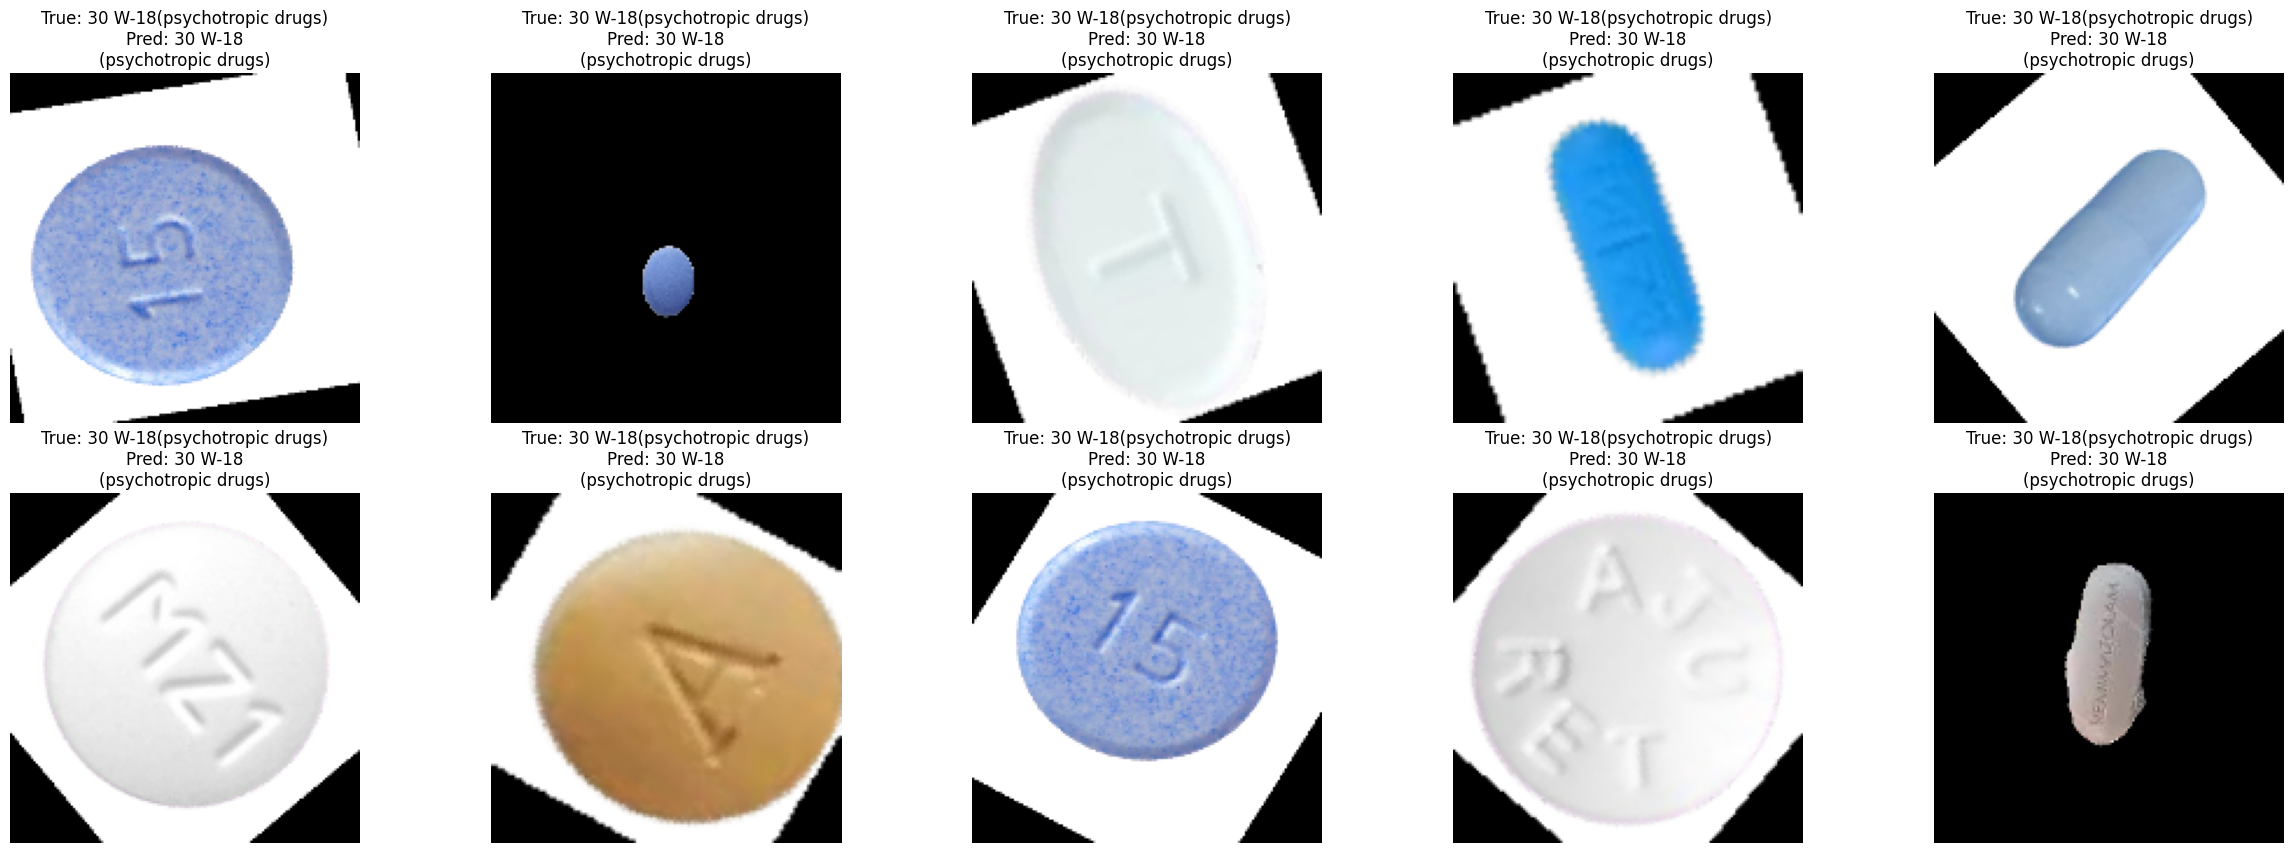

In [41]:
################# 약 이름이 다 똑같음 이상
# 시각화할 이미지 개수
num_images = 10

plt.figure(figsize=(30, 10))
for i in range(num_images):
    true_label = decoded_labels[y_test[i]]  # 실제 라벨 정보 디코딩
    pred_label = decoded_labels[y_pred_classes[i]]  # 예측 라벨 정보 디코딩
    true_classification = classify_drug(true_label)  # 실제 라벨 기반 분류
    pred_classification = classify_drug(pred_label)  # 예측 라벨 기반 분류

    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[i], cmap='gray')
    plt.title(f"True: {true_label}({true_classification})\nPred: {pred_label}\n({pred_classification})")
    plt.axis('off')

plt.show()

In [40]:
##### 각 이미지에 대해 올바른 'true_label'과 'pred_label'이 올바르게 할당되었는지 파악 => 모두 값 동일 => 분류모델이 모든 이미지를 같은 클래스로 예측중임?
num_images = 10

for i in range(num_images):
    true_label_index = y_test[i]
    pred_label_index = y_pred_classes[i]

    true_label = decoded_labels[true_label_index]  # 실제 라벨 정보 디코딩
    pred_label = decoded_labels[pred_label_index]  # 예측 라벨 정보 디코딩
    true_classification = classify_drug(true_label)  # 실제 라벨 기반 분류
    pred_classification = classify_drug(pred_label)  # 예측 라벨 기반 분류

    # 출력 확인
    print(f"Image {i + 1}: True Label: {true_label}, Predicted Label: {pred_label}")

plt.show()


Image 1: True Label: 30 W-18, Predicted Label: 30 W-18
Image 2: True Label: 30 W-18, Predicted Label: 30 W-18
Image 3: True Label: 30 W-18, Predicted Label: 30 W-18
Image 4: True Label: 30 W-18, Predicted Label: 30 W-18
Image 5: True Label: 30 W-18, Predicted Label: 30 W-18
Image 6: True Label: 30 W-18, Predicted Label: 30 W-18
Image 7: True Label: 30 W-18, Predicted Label: 30 W-18
Image 8: True Label: 30 W-18, Predicted Label: 30 W-18
Image 9: True Label: 30 W-18, Predicted Label: 30 W-18
Image 10: True Label: 30 W-18, Predicted Label: 30 W-18


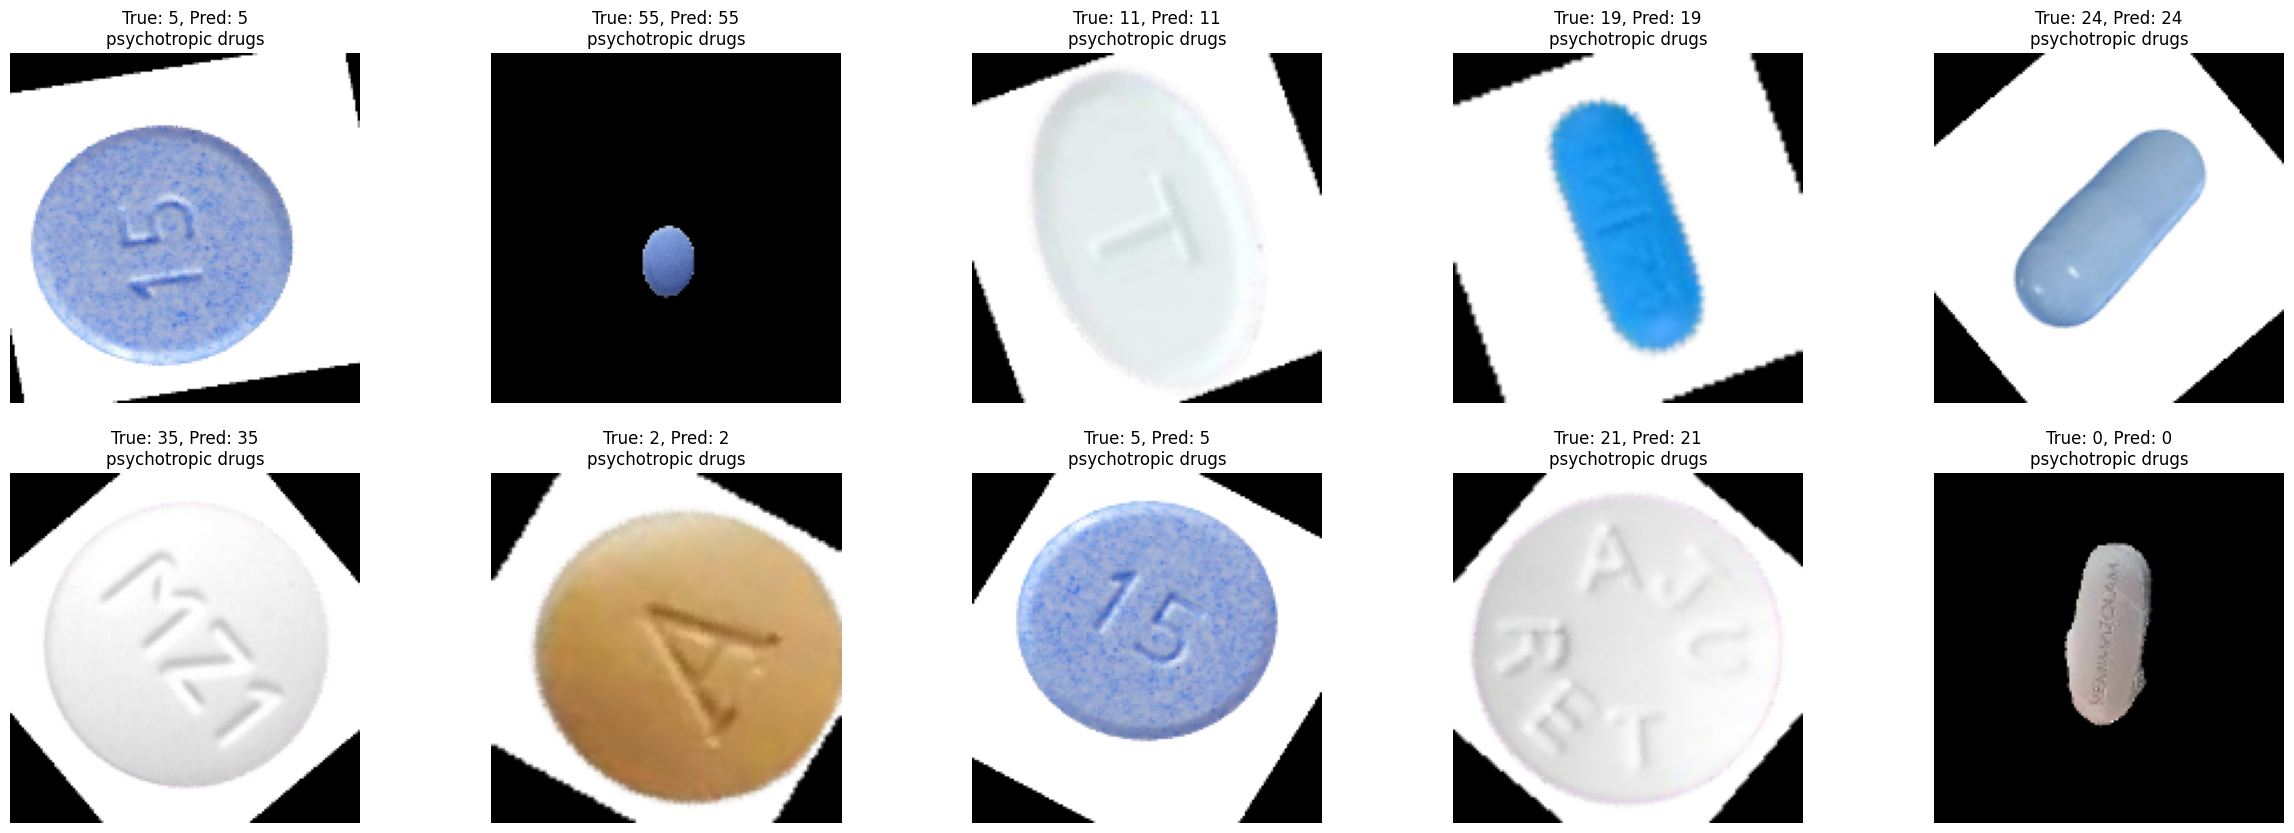

In [26]:
# 시각화할 이미지 개수
num_images = 10

plt.figure(figsize=(30, 10))
for i in range(num_images):
    true_label = y_test[i]  # 인코딩된 실제 라벨
    pred_label = y_pred_classes[i]  # 인코딩된 예측 라벨

    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[i], cmap='gray')
    plt.title(f"True: {true_label}, Pred: {pred_label}\n{classify_drug(decoded_labels[pred_label])}")
    plt.axis('off')

plt.show()

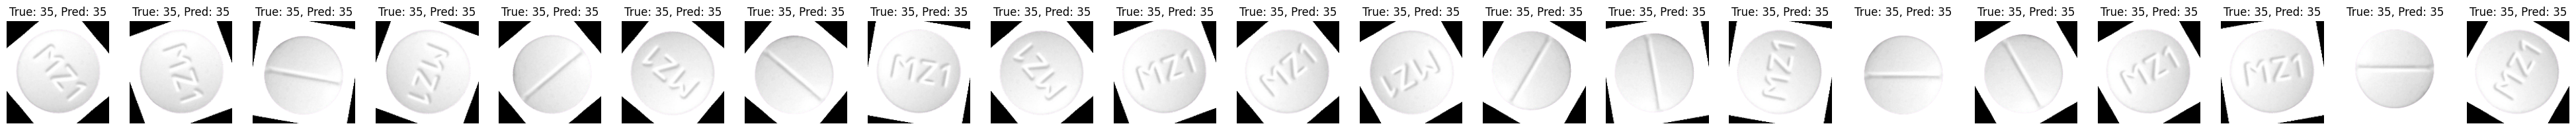

In [27]:
# 인코딩된 값이 5인 이미지를 찾기
indices_with_label_5 = np.where(y_test == 35)[0]

plt.figure(figsize=(50, 5))
for i, idx in enumerate(indices_with_label_5):
    plt.subplot(1, len(indices_with_label_5), i + 1)
    plt.imshow(x_test[idx], cmap='gray')
    plt.title(f"True: {y_test[idx]}, Pred: {y_pred_classes[idx]}")
    plt.axis('off')

plt.show()
